<a href="https://colab.research.google.com/github/saketh-kuppili/Brain-Tumour/blob/main/Brain_Tumor_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor Classification: ResNet-50 with CBAM Attention

**Objective:** Build and compare two PyTorch CNN models for trustworthy brain tumor classification from MRI images:
1. **Baseline ResNet-50**: Standard ResNet-50 without attention mechanisms
2. **ResNet-50 + CBAM**: ResNet-50 with Convolutional Block Attention Module (channel + spatial attention)

**Dataset:** 4-class classification (glioma, meningioma, pituitary, no tumor) using PyTorch ImageFolder from the Training/ and Testing/ directories.

**Key Features:**
- CBAM implemented from scratch (channel and spatial attention)
- Modular, production-ready PyTorch code
- Comprehensive metrics: accuracy, per-class F1, confusion matrix
- Training with checkpointing and LR scheduling
- Attention map visualization on MRI images
- Clean markdown documentation throughout

## 1. Imports & Configuration

Import all necessary libraries and define configuration variables for the entire experiment.

In [11]:
# import os

# # IMPORTANT: Replace 'your_file.zip' with the actual name of your uploaded zip file.
# zip_file_name = 'Training.zip' # <--- Please update this with your actual zip file name

# # Check if the file exists
# if os.path.exists(zip_file_name):
#     print(f"Unzipping {zip_file_name}...")
#     # Use the unzip command. The -q flag makes it quiet, -o overwrites existing files.
#     !unzip -q -o {zip_file_name}
#     print(f"Successfully unzipped {zip_file_name}.")
# else:
#     print(f"Error: '{zip_file_name}' not found. Please ensure you have uploaded the file and the name is correct.")

# # List contents of the current directory to verify unzipping (optional)
# !ls -F

In [12]:
# Environment diagnostic — check required packages and kernel path
import importlib
import sys

required = ['torch', 'torchvision', 'tqdm', 'sklearn', 'scipy', 'matplotlib', 'seaborn']
missing = []
for pkg in required:
    try:
        importlib.import_module(pkg)
    except Exception:
        missing.append(pkg)

print('Python executable:', sys.executable)
print('Python version   :', sys.version.splitlines()[0])

if not missing:
    print('\nAll required packages appear to be installed.')
    try:
        import torch
        print('torch version:', getattr(torch, '__version__', 'unknown'))
    except Exception:
        pass
else:
    print('\nMissing packages:', missing)
    print('\nInstall with pip (recommended):')
    print('python -m pip install --upgrade pip')
    print('python -m pip install ' + ' '.join(missing))
    print('\nFor PyTorch, follow the official selector (CUDA vs CPU): https://pytorch.org/get-started/locally/')
    print('\nIf you use conda, you can install with:')
    print('conda install -y ' + ' '.join(missing))
    print('\nImportant: Ensure the Jupyter kernel is using the same Python environment shown above.')
    print('If not, install ipykernel in that environment and add a kernel:')
    print('python -m pip install ipykernel')
    print("python -m ipykernel install --user --name myenv --display-name \"Python (myenv)\"")

print('\nAfter installing, restart the kernel and re-run the notebook cells.')

Python executable: /usr/bin/python3
Python version   : 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]

All required packages appear to be installed.
torch version: 2.8.0+cu126

After installing, restart the kernel and re-run the notebook cells.


In [13]:
import os
import json
import random
from pathlib import Path
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

# Set style for visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# ===== Configuration =====
CONFIG = {
    'batch_size': 32,
    'learning_rate': 1e-3,
    'weight_decay': 1e-5,
    'epochs': 50,
    'num_workers': 4,
    'image_size': 224,
    'num_classes': 4,
    'checkpoint_dir': './checkpoints',
    'seed': 42,
    'cbam_reduction': 16,  # Reduction ratio for CBAM channel attention
    'pretrained': False,  # Start with random weights for fair comparison
}

# Create checkpoint directory
os.makedirs(CONFIG['checkpoint_dir'], exist_ok=True)
print(f"Config: {json.dumps(CONFIG, indent=2)}")

Using device: cuda
Config: {
  "batch_size": 32,
  "learning_rate": 0.001,
  "weight_decay": 1e-05,
  "epochs": 50,
  "num_workers": 4,
  "image_size": 224,
  "num_classes": 4,
  "checkpoint_dir": "./checkpoints",
  "seed": 42,
  "cbam_reduction": 16,
  "pretrained": false
}


## 2. Reproducibility & Utilities

Set deterministic seeds, implement checkpoint saving/loading, and utility functions for training.

In [14]:
def set_seed(seed: int):
    """Set random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def to_device(batch, device):
    """Move batch (images, labels) to specified device."""
    images, labels = batch
    return images.to(device), labels.to(device)

def save_checkpoint(model, optimizer, scheduler, epoch, best_metric, model_name, config):
    """Save model checkpoint with all state."""
    checkpoint = {
        'epoch': epoch,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'scheduler_state': scheduler.state_dict() if scheduler else None,
        'best_metric': best_metric,
        'config': config,
    }
    path = os.path.join(config['checkpoint_dir'], f"{model_name}_best.pt")
    torch.save(checkpoint, path)
    print(f"✓ Checkpoint saved: {path}")

def load_checkpoint(model, optimizer, scheduler, model_name, config, device):
    """Load model checkpoint and restore state."""
    path = os.path.join(config['checkpoint_dir'], f"{model_name}_best.pt")
    if os.path.exists(path):
        checkpoint = torch.load(path, map_location=device)
        model.load_state_dict(checkpoint['model_state'])
        optimizer.load_state_dict(checkpoint['optimizer_state'])
        if scheduler and checkpoint['scheduler_state']:
            scheduler.load_state_dict(checkpoint['scheduler_state'])
        print(f"✓ Checkpoint loaded from epoch {checkpoint['epoch']}, best_metric={checkpoint['best_metric']:.4f}")
        return checkpoint['epoch'], checkpoint['best_metric']
    return 0, 0.0

class MetricsLogger:
    """Simple training history logger."""
    def __init__(self):
        self.history = defaultdict(list)

    def log(self, **kwargs):
        for key, value in kwargs.items():
            self.history[key].append(value)

    def save(self, path):
        with open(path, 'w') as f:
            json.dump(self.history, f, indent=2)

    def plot_curves(self, figsize=(14, 5)):
        fig, axes = plt.subplots(1, 2, figsize=figsize)

        if 'train_loss' in self.history and 'val_loss' in self.history:
            axes[0].plot(self.history['train_loss'], label='Train Loss', marker='o')
            axes[0].plot(self.history['val_loss'], label='Val Loss', marker='s')
            axes[0].set_xlabel('Epoch')
            axes[0].set_ylabel('Loss')
            axes[0].set_title('Training & Validation Loss')
            axes[0].legend()
            axes[0].grid(True, alpha=0.3)

        if 'train_acc' in self.history and 'val_acc' in self.history:
            axes[1].plot(self.history['train_acc'], label='Train Accuracy', marker='o')
            axes[1].plot(self.history['val_acc'], label='Val Accuracy', marker='s')
            axes[1].set_xlabel('Epoch')
            axes[1].set_ylabel('Accuracy')
            axes[1].set_title('Training & Validation Accuracy')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        return fig

# Set seed for reproducibility
set_seed(CONFIG['seed'])

## 3. Data Transforms & Dataset Loading

Define image transformations and load datasets using PyTorch's ImageFolder.

In [15]:
# Image Normalization Stats (ImageNet)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Training transforms: augmentation for robustness
train_transforms = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
    transforms.CenterCrop(CONFIG['image_size']),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

# Test transforms: deterministic, minimal augmentation
test_transforms = transforms.Compose([
    transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
    transforms.CenterCrop(CONFIG['image_size']),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

# Load datasets using ImageFolder
train_dataset = datasets.ImageFolder(
    root='./Training',
    transform=train_transforms
)

test_dataset = datasets.ImageFolder(
    root='./Testing',
    transform=test_transforms
)

# Class mappings
class_to_idx = train_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

print(f"✓ Training samples: {len(train_dataset)}")
print(f"✓ Testing samples: {len(test_dataset)}")
print(f"✓ Classes: {list(idx_to_class.values())}")
print(f"✓ Class mapping: {class_to_idx}")

✓ Training samples: 5712
✓ Testing samples: 1311
✓ Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
✓ Class mapping: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [16]:
!ls -F

checkpoints/  sample_data/  Testing.zip  Training.zip
__MACOSX/     Testing/	    Training/


## 4. DataLoaders & Sample Visualization

Create data loaders and visualize sample MRI images to verify data loading.

✓ Train batches: 179
✓ Test batches: 41


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


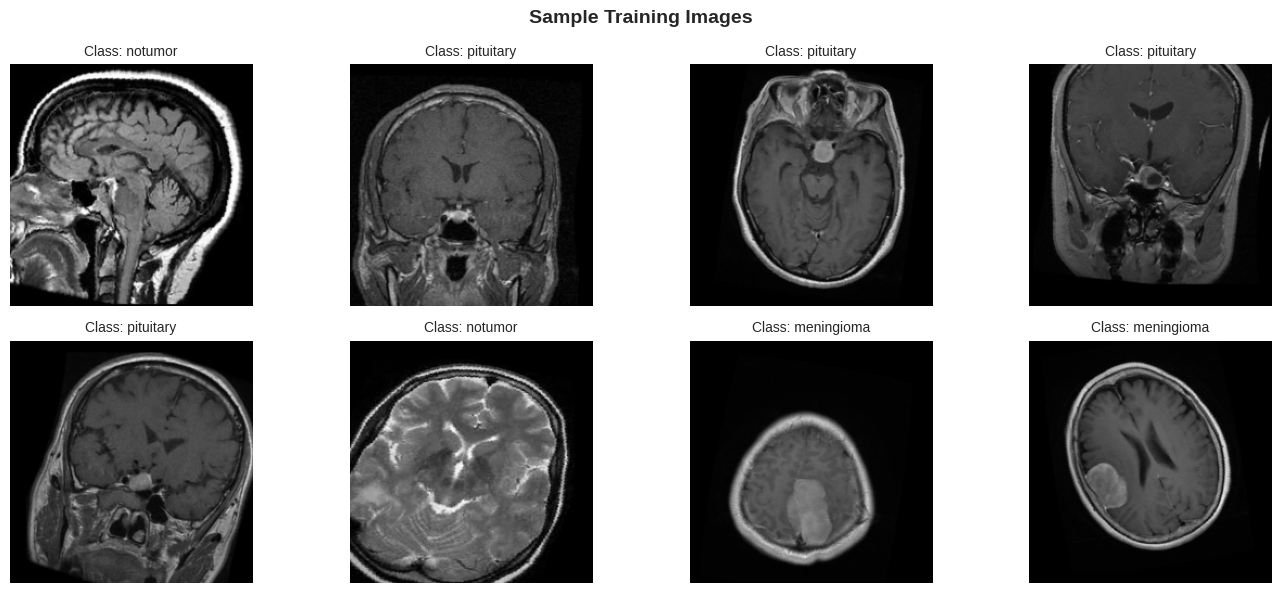

In [17]:
# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=CONFIG['num_workers'],
    pin_memory=True,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=True,
)

print(f"✓ Train batches: {len(train_loader)}")
print(f"✓ Test batches: {len(test_loader)}")

# Visualize sample images
def plot_sample_batch(dataloader, idx_to_class, num_samples=8):
    """Visualize a batch of MRI images."""
    images, labels = next(iter(dataloader))

    # Denormalize for visualization
    images = images * torch.tensor(IMAGENET_STD).view(1, 3, 1, 1) + torch.tensor(IMAGENET_MEAN).view(1, 3, 1, 1)
    images = torch.clamp(images, 0, 1)

    num_samples = min(num_samples, len(images))
    fig, axes = plt.subplots(2, 4, figsize=(14, 6))
    axes = axes.flatten()

    for i in range(num_samples):
        ax = axes[i]
        img = images[i].permute(1, 2, 0).numpy()
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Class: {idx_to_class[labels[i].item()]}", fontsize=10)
        ax.axis('off')

    plt.suptitle("Sample Training Images", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_sample_batch(train_loader, idx_to_class)

## 5. CBAM Implementation (from Scratch)

Implement Convolutional Block Attention Module with channel and spatial attention mechanisms.

### Channel Attention
For each channel, compute attention weights using both global average and max pooling:
$$\text{CA}(F) = \sigma(MLP(AvgPool(F)) + MLP(MaxPool(F)))$$

### Spatial Attention
Compute attention maps by concatenating average and max pooling across the channel dimension:
$$\text{SA}(F) = \sigma(f^{7 \times 7}([\text{AvgPool}(F); \text{MaxPool}(F)]))$$

In [18]:
class ChannelAttention(nn.Module):
    """Channel Attention Module: learns which channels are important."""
    def __init__(self, num_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        # Shared MLP with reduction
        self.fc = nn.Sequential(
            nn.Linear(num_channels, num_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(num_channels // reduction, num_channels, bias=False),
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x shape: (B, C, H, W)
        avg_out = self.fc(self.avg_pool(x).view(x.size(0), -1))
        max_out = self.fc(self.max_pool(x).view(x.size(0), -1))
        out = avg_out + max_out
        return self.sigmoid(out).view(x.size(0), -1, 1, 1)

class SpatialAttention(nn.Module):
    """Spatial Attention Module: learns which spatial regions are important."""
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x shape: (B, C, H, W)
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(x_cat)
        return self.sigmoid(out)

class CBAM(nn.Module):
    """Convolutional Block Attention Module: combines channel and spatial attention."""
    def __init__(self, num_channels, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(num_channels, reduction)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        # Apply channel attention
        ca_out = x * self.channel_attention(x)
        # Apply spatial attention
        sa_out = ca_out * self.spatial_attention(ca_out)
        return sa_out

    def get_spatial_attention(self, x):
        """Extract spatial attention map (for visualization)."""
        with torch.no_grad():
            ca_out = x * self.channel_attention(x)
            sa_map = self.spatial_attention(ca_out)
        return sa_map

print("✓ CBAM modules defined (Channel Attention + Spatial Attention)")

✓ CBAM modules defined (Channel Attention + Spatial Attention)


## 6. ResNet-50 with CBAM Integration

Modify ResNet-50 bottleneck blocks to include CBAM attention after each block.

In [19]:
class BottleneckWithCBAM(nn.Module):
    """Bottleneck block with CBAM attention."""
    expansion = 4

    def __init__(self, original_bottleneck, cbam_module):
        super(BottleneckWithCBAM, self).__init__()
        self.bottleneck = original_bottleneck
        self.cbam = cbam_module

    def forward(self, x):
        identity = x
        out = self.bottleneck.conv1(x)
        out = self.bottleneck.bn1(out)
        out = self.bottleneck.relu(out)

        out = self.bottleneck.conv2(out)
        out = self.bottleneck.bn2(out)
        out = self.bottleneck.relu(out)

        out = self.bottleneck.conv3(out)
        out = self.bottleneck.bn3(out)

        # Shortcut connection
        if self.bottleneck.downsample is not None:
            identity = self.bottleneck.downsample(x)

        out += identity
        out = self.bottleneck.relu(out)

        # Apply CBAM after residual block
        out = self.cbam(out)
        return out

def add_cbam_to_resnet50(model, reduction=16):
    """Add CBAM modules to ResNet-50 bottleneck blocks."""
    for layer in [model.layer1, model.layer2, model.layer3, model.layer4]:
        for i, block in enumerate(layer):
            # Get the output channels of the bottleneck
            out_channels = block.conv3.out_channels
            cbam = CBAM(out_channels, reduction=reduction)
            # Wrap bottleneck with CBAM
            layer[i] = BottleneckWithCBAM(block, cbam)
    return model

print("✓ ResNet-50 + CBAM wrapper defined")

✓ ResNet-50 + CBAM wrapper defined


## 7. Model Factory

Create a factory function to build baseline and CBAM-augmented models.

In [21]:
def build_model(mode='baseline', num_classes=4, pretrained=False, cbam_reduction=16):
    """
    Build ResNet-50 model with or without CBAM attention.

    Args:
        mode: 'baseline' or 'cbam'
        num_classes: Number of output classes
        pretrained: Use pretrained ImageNet weights
        cbam_reduction: Reduction ratio for CBAM channel attention

    Returns:
        model, parameter count
    """
    # Use modern torchvision API with weights; avoid passing deprecated 'pretrained'
    try:
        from torchvision.models import ResNet50_Weights
        weights = ResNet50_Weights.DEFAULT if pretrained else None
    except Exception:
        # Fallback for very old torchvision; None means random init
        weights = None
    model = models.resnet50(weights=weights)

    if mode == 'cbam':
        model = add_cbam_to_resnet50(model, reduction=cbam_reduction)

    # Replace final classification layer
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    # Move to device
    model = model.to(DEVICE)

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"✓ Model ({mode.upper()}) built:")
    print(f"  - Total params: {total_params:,}")
    print(f"  - Trainable params: {trainable_params:,}")

    return model, total_params

# Build both models
model_baseline, params_baseline = build_model(mode='baseline', num_classes=CONFIG['num_classes'], pretrained=CONFIG['pretrained'])
model_cbam, params_cbam = build_model(mode='cbam', num_classes=CONFIG['num_classes'], pretrained=CONFIG['pretrained'], cbam_reduction=CONFIG['cbam_reduction'])

✓ Model (BASELINE) built:
  - Total params: 23,516,228
  - Trainable params: 23,516,228
✓ Model (CBAM) built:
  - Total params: 26,032,740
  - Trainable params: 26,032,740


## 8. Metrics & Loss Functions

Define loss, accuracy, and per-class F1 scores.

### Per-Class F1 Score
$$F1 = \frac{2 \cdot TP}{2 \cdot TP + FP + FN}$$

where TP = True Positives, FP = False Positives, FN = False Negatives

In [22]:
# Loss function
criterion = nn.CrossEntropyLoss()

def compute_metrics(y_true, y_pred, idx_to_class):
    """
    Compute accuracy, per-class precision, recall, F1.

    Args:
        y_true: Ground truth labels (numpy array)
        y_pred: Predicted labels (numpy array)
        idx_to_class: Class index to name mapping

    Returns:
        Dictionary with metrics
    """
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(idx_to_class))))
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=list(range(len(idx_to_class))), average=None
    )
    accuracy = accuracy_score(y_true, y_pred)

    metrics = {
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'per_class': {}
    }

    for i, class_name in idx_to_class.items():
        metrics['per_class'][class_name] = {
            'precision': float(precision[i]),
            'recall': float(recall[i]),
            'f1': float(f1[i]),
            'support': int(cm[i].sum())
        }

    # Macro-averaged F1
    metrics['macro_f1'] = float(f1.mean())

    return metrics

def print_metrics(metrics, idx_to_class):
    """Pretty-print metrics."""
    print(f"\n{'='*70}")
    print(f"Overall Accuracy: {metrics['accuracy']:.4f}")
    print(f"Macro-Averaged F1: {metrics['macro_f1']:.4f}")
    print(f"\n{'Class':<15} {'Precision':<12} {'Recall':<12} {'F1':<12} {'Support':<10}")
    print(f"{'-'*70}")
    for i, class_name in idx_to_class.items():
        stats = metrics['per_class'][class_name]
        print(f"{class_name:<15} {stats['precision']:<12.4f} {stats['recall']:<12.4f} {stats['f1']:<12.4f} {stats['support']:<10}")
    print(f"{'='*70}\n")

print("✓ Metrics functions defined")

✓ Metrics functions defined


## 9. Training Loop

Train both models with progress tracking, checkpointing, and per-epoch logging.

In [24]:
def train_one_epoch(model, dataloader, criterion, optimizer, device, idx_to_class):
    """
    Train for one epoch.

    Returns:
        Dictionary with training metrics
    """
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    pbar = tqdm(dataloader, desc="Training", leave=False)
    for images, labels in pbar:
        images, labels = to_device((images, labels), device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate metrics
        running_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        pbar.set_postfix(loss=f"{loss.item():.4f}")

    # Compute epoch metrics
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    epoch_loss = running_loss / len(dataloader.dataset)
    metrics = compute_metrics(all_labels, all_preds, idx_to_class)

    return {
        'loss': epoch_loss,
        'accuracy': metrics['accuracy'],
        'macro_f1': metrics['macro_f1'],
        'metrics': metrics
    }

def evaluate(model, dataloader, criterion, device, idx_to_class):
    """
    Evaluate on validation/test set.

    Returns:
        Dictionary with evaluation metrics
    """
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating", leave=False):
            images, labels = to_device((images, labels), device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute metrics
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    epoch_loss = running_loss / len(dataloader.dataset)
    metrics = compute_metrics(all_labels, all_preds, idx_to_class)

    return {
        'loss': epoch_loss,
        'accuracy': metrics['accuracy'],
        'macro_f1': metrics['macro_f1'],
        'metrics': metrics
    }

print("✓ Training and evaluation functions defined")

✓ Training and evaluation functions defined


## 10. CBAM Attention Visualization

Visualize spatial attention maps overlaid on original MRI images.

In [25]:
def get_cbam_attention_maps(model, dataloader, device, idx_to_class, num_samples=5):
    """
    Extract CBAM spatial attention maps from layer4 for visualization.

    Args:
        model: ResNet-50 with CBAM (must have BottleneckWithCBAM in layer4)
        dataloader: DataLoader for extracting samples
        device: torch device
        idx_to_class: Class index mapping
        num_samples: Number of samples to extract

    Returns:
        Dictionary with images, predictions, labels, and attention maps
    """
    model.eval()

    # Hook to capture attention maps
    attention_maps = []

    def hook_fn(module, input, output):
        if hasattr(module, 'cbam'):
            # Get spatial attention map from CBAM
            x = input[0]
            with torch.no_grad():
                ca_out = x * module.cbam.channel_attention(x)
                sa_map = module.cbam.spatial_attention(ca_out)
                attention_maps.append(sa_map.cpu())

    # Register hooks on layer4 blocks
    handles = []
    for block in model.layer4:
        h = block.register_forward_hook(hook_fn)
        handles.append(h)

    results = {
        'images': [],
        'predictions': [],
        'labels': [],
        'attention_maps': [],
        'class_names': []
    }

    with torch.no_grad():
        for images, labels in dataloader:
            if len(results['images']) >= num_samples:
                break

            images_orig = images.clone()
            images, labels = to_device((images, labels), device)

            attention_maps.clear()
            outputs = model(images)
            preds = outputs.argmax(dim=1)

            for i in range(min(len(images), num_samples - len(results['images']))):
                results['images'].append(images_orig[i])
                results['predictions'].append(idx_to_class[preds[i].item()])
                results['labels'].append(idx_to_class[labels[i].item()])
                results['class_names'].append(idx_to_class[preds[i].item()])

                # Use last attention map from layer4
                if attention_maps:
                    att_map = attention_maps[-1][i:i+1]
                    results['attention_maps'].append(att_map)

    # Remove hooks
    for h in handles:
        h.remove()

    return results

def visualize_attention(results, idx_to_class, figsize=(16, 10)):
    """
    Visualize original images with overlaid CBAM attention maps.

    Args:
        results: Dictionary from get_cbam_attention_maps
        idx_to_class: Class mapping
        figsize: Figure size
    """
    num_samples = len(results['images'])
    fig, axes = plt.subplots(num_samples, 3, figsize=figsize)
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i in range(num_samples):
        # Original image (denormalized)
        img = results['images'][i]
        img = img * torch.tensor(IMAGENET_STD).view(3, 1, 1) + torch.tensor(IMAGENET_MEAN).view(3, 1, 1)
        img = torch.clamp(img, 0, 1).permute(1, 2, 0).numpy()

        axes[i, 0].imshow(img, cmap='gray')
        axes[i, 0].set_title(f"Original\nTrue: {results['labels'][i]}\nPred: {results['predictions'][i]}", fontsize=10)
        axes[i, 0].axis('off')

        # Attention map
        if results['attention_maps']:
            att_map = results['attention_maps'][i].squeeze().numpy()
            att_map = (att_map - att_map.min()) / (att_map.max() - att_map.min() + 1e-8)
            axes[i, 1].imshow(att_map, cmap='hot')
            axes[i, 1].set_title(f"CBAM Attention Map", fontsize=10)
            axes[i, 1].axis('off')

            # Overlay: resize attention map to match image
            from scipy.ndimage import zoom
            att_resized = zoom(att_map, (img.shape[0] / att_map.shape[0], img.shape[1] / att_map.shape[1]), order=1)
            overlay = img.copy()
            overlay[..., 0] = 0.5 * img[..., 0] + 0.5 * att_resized
            axes[i, 2].imshow(overlay, cmap='gray')
            axes[i, 2].set_title(f"Attention Overlay", fontsize=10)
            axes[i, 2].axis('off')
        else:
            axes[i, 1].text(0.5, 0.5, 'No attention data', ha='center', va='center')
            axes[i, 1].axis('off')
            axes[i, 2].axis('off')

    plt.suptitle("CBAM Spatial Attention Visualization on MRI Images", fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig

print("✓ Attention visualization functions defined")

✓ Attention visualization functions defined


## 11. Confusion Matrix Visualization

Plot confusion matrices for model evaluation.

In [26]:
def plot_confusion_matrix(cm, idx_to_class, title='Confusion Matrix', normalize=True):
    """
    Plot confusion matrix.

    Args:
        cm: Confusion matrix from sklearn
        idx_to_class: Class mapping
        title: Plot title
        normalize: Whether to normalize by row
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2%'
    else:
        fmt = 'd'

    fig, ax = plt.subplots(figsize=(8, 7))
    class_names = [idx_to_class[i] for i in range(len(idx_to_class))]

    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names,
                cbar_kws={'label': 'Accuracy' if normalize else 'Count'},
                ax=ax)
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig

print("✓ Confusion matrix visualization defined")

✓ Confusion matrix visualization defined


## 12. Experiment Runner: Train & Compare Both Models

Train both baseline and CBAM models on the same dataset and compare results.

In [27]:
def run_experiment(model, model_name, train_loader, test_loader, config, idx_to_class):
    """
    Train and evaluate a model, logging metrics and saving best checkpoint.
    """
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    scheduler = CosineAnnealingLR(optimizer, T_max=config['epochs'])
    logger = MetricsLogger()
    best_f1 = 0.0
    best_epoch = 0

    for epoch in range(1, config['epochs'] + 1):
        print(f"\nEpoch {epoch}/{config['epochs']} [{model_name}]")
        train_metrics = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE, idx_to_class)
        val_metrics = evaluate(model, test_loader, criterion, DEVICE, idx_to_class)
        scheduler.step()

        logger.log(
            train_loss=train_metrics['loss'],
            train_acc=train_metrics['accuracy'],
            train_f1=train_metrics['macro_f1'],
            val_loss=val_metrics['loss'],
            val_acc=val_metrics['accuracy'],
            val_f1=val_metrics['macro_f1']
        )

        print(f"Train Loss: {train_metrics['loss']:.4f} | Acc: {train_metrics['accuracy']:.4f} | F1: {train_metrics['macro_f1']:.4f}")
        print(f"Val   Loss: {val_metrics['loss']:.4f} | Acc: {val_metrics['accuracy']:.4f} | F1: {val_metrics['macro_f1']:.4f}")

        # Save best model by validation F1
        if val_metrics['macro_f1'] > best_f1:
            best_f1 = val_metrics['macro_f1']
            best_epoch = epoch
            save_checkpoint(model, optimizer, scheduler, epoch, best_f1, model_name, config)

    print(f"\nBest Val F1: {best_f1:.4f} at epoch {best_epoch}")
    logger.save(os.path.join(config['checkpoint_dir'], f"{model_name}_history.json"))
    return logger

# Run experiments for both models
logger_baseline = run_experiment(model_baseline, 'baseline', train_loader, test_loader, CONFIG, idx_to_class)
logger_cbam = run_experiment(model_cbam, 'cbam', train_loader, test_loader, CONFIG, idx_to_class)


Epoch 1/50 [baseline]


Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.7934 | Acc: 0.6957 | F1: 0.6868
Val   Loss: 0.8932 | Acc: 0.6209 | F1: 0.5326
✓ Checkpoint saved: ./checkpoints/baseline_best.pt

Epoch 2/50 [baseline]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.6124 | Acc: 0.7682 | F1: 0.7607
Val   Loss: 0.5473 | Acc: 0.7895 | F1: 0.7753
✓ Checkpoint saved: ./checkpoints/baseline_best.pt

Epoch 3/50 [baseline]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.5154 | Acc: 0.8116 | F1: 0.8057
Val   Loss: 3.6153 | Acc: 0.5789 | F1: 0.4745

Epoch 4/50 [baseline]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.4396 | Acc: 0.8484 | F1: 0.8439
Val   Loss: 0.5972 | Acc: 0.8070 | F1: 0.7835
✓ Checkpoint saved: ./checkpoints/baseline_best.pt

Epoch 5/50 [baseline]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.3938 | Acc: 0.8543 | F1: 0.8502
Val   Loss: 0.6280 | Acc: 0.7323 | F1: 0.7062

Epoch 6/50 [baseline]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.3301 | Acc: 0.8762 | F1: 0.8730
Val   Loss: 0.6142 | Acc: 0.8177 | F1: 0.7860
✓ Checkpoint saved: ./checkpoints/baseline_best.pt

Epoch 7/50 [baseline]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.3044 | Acc: 0.8913 | F1: 0.8881
Val   Loss: 0.4762 | Acc: 0.8375 | F1: 0.8321
✓ Checkpoint saved: ./checkpoints/baseline_best.pt

Epoch 8/50 [baseline]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.3110 | Acc: 0.8946 | F1: 0.8916
Val   Loss: 1.5943 | Acc: 0.6011 | F1: 0.5084

Epoch 9/50 [baseline]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.2555 | Acc: 0.9091 | F1: 0.9067
Val   Loss: 0.6275 | Acc: 0.8200 | F1: 0.8275

Epoch 10/50 [baseline]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.2599 | Acc: 0.9076 | F1: 0.9047
Val   Loss: 0.5136 | Acc: 0.8322 | F1: 0.8174

Epoch 11/50 [baseline]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.2389 | Acc: 0.9140 | F1: 0.9119
Val   Loss: 0.3147 | Acc: 0.8848 | F1: 0.8851
✓ Checkpoint saved: ./checkpoints/baseline_best.pt

Epoch 12/50 [baseline]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.2165 | Acc: 0.9244 | F1: 0.9220
Val   Loss: 0.6114 | Acc: 0.8246 | F1: 0.8109

Epoch 13/50 [baseline]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.2074 | Acc: 0.9298 | F1: 0.9278
Val   Loss: 0.6174 | Acc: 0.7956 | F1: 0.7662

Epoch 14/50 [baseline]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.1898 | Acc: 0.9336 | F1: 0.9317
Val   Loss: 0.1798 | Acc: 0.9329 | F1: 0.9304
✓ Checkpoint saved: ./checkpoints/baseline_best.pt

Epoch 15/50 [baseline]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.1800 | Acc: 0.9375 | F1: 0.9357
Val   Loss: 2.3874 | Acc: 0.5751 | F1: 0.4456

Epoch 16/50 [baseline]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.1687 | Acc: 0.9424 | F1: 0.9407
Val   Loss: 0.6964 | Acc: 0.7788 | F1: 0.7515

Epoch 17/50 [baseline]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.1508 | Acc: 0.9491 | F1: 0.9475
Val   Loss: 0.7432 | Acc: 0.7712 | F1: 0.7426

Epoch 18/50 [baseline]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.1417 | Acc: 0.9510 | F1: 0.9495
Val   Loss: 0.3609 | Acc: 0.8787 | F1: 0.8741

Epoch 19/50 [baseline]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.1598 | Acc: 0.9436 | F1: 0.9420
Val   Loss: 0.3939 | Acc: 0.8665 | F1: 0.8569

Epoch 20/50 [baseline]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.1357 | Acc: 0.9545 | F1: 0.9532
Val   Loss: 0.1911 | Acc: 0.9390 | F1: 0.9349
✓ Checkpoint saved: ./checkpoints/baseline_best.pt

Epoch 21/50 [baseline]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.1474 | Acc: 0.9503 | F1: 0.9490
Val   Loss: 0.2471 | Acc: 0.9230 | F1: 0.9162

Epoch 22/50 [baseline]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.1149 | Acc: 0.9608 | F1: 0.9596
Val   Loss: 0.1412 | Acc: 0.9474 | F1: 0.9444
✓ Checkpoint saved: ./checkpoints/baseline_best.pt

Epoch 23/50 [baseline]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.1204 | Acc: 0.9564 | F1: 0.9552
Val   Loss: 0.1291 | Acc: 0.9527 | F1: 0.9510
✓ Checkpoint saved: ./checkpoints/baseline_best.pt

Epoch 24/50 [baseline]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.1085 | Acc: 0.9615 | F1: 0.9605
Val   Loss: 0.0960 | Acc: 0.9657 | F1: 0.9641
✓ Checkpoint saved: ./checkpoints/baseline_best.pt

Epoch 25/50 [baseline]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.1075 | Acc: 0.9622 | F1: 0.9611
Val   Loss: 0.0894 | Acc: 0.9741 | F1: 0.9727
✓ Checkpoint saved: ./checkpoints/baseline_best.pt

Epoch 26/50 [baseline]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.1012 | Acc: 0.9655 | F1: 0.9645
Val   Loss: 0.1133 | Acc: 0.9550 | F1: 0.9550

Epoch 27/50 [baseline]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.0839 | Acc: 0.9699 | F1: 0.9689
Val   Loss: 0.1059 | Acc: 0.9680 | F1: 0.9665

Epoch 28/50 [baseline]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.0832 | Acc: 0.9743 | F1: 0.9735
Val   Loss: 0.2266 | Acc: 0.9268 | F1: 0.9220

Epoch 29/50 [baseline]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.0594 | Acc: 0.9786 | F1: 0.9780
Val   Loss: 0.4417 | Acc: 0.8688 | F1: 0.8599

Epoch 30/50 [baseline]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.0644 | Acc: 0.9786 | F1: 0.9780
Val   Loss: 0.0523 | Acc: 0.9817 | F1: 0.9807
✓ Checkpoint saved: ./checkpoints/baseline_best.pt

Epoch 31/50 [baseline]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.0696 | Acc: 0.9764 | F1: 0.9758
Val   Loss: 0.0848 | Acc: 0.9725 | F1: 0.9708

Epoch 32/50 [baseline]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.0553 | Acc: 0.9804 | F1: 0.9797
Val   Loss: 0.0650 | Acc: 0.9825 | F1: 0.9812
✓ Checkpoint saved: ./checkpoints/baseline_best.pt

Epoch 33/50 [baseline]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.0582 | Acc: 0.9806 | F1: 0.9802
Val   Loss: 0.0719 | Acc: 0.9741 | F1: 0.9724

Epoch 34/50 [baseline]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.0329 | Acc: 0.9886 | F1: 0.9883
Val   Loss: 0.1402 | Acc: 0.9527 | F1: 0.9507

Epoch 35/50 [baseline]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.0364 | Acc: 0.9877 | F1: 0.9873
Val   Loss: 0.0416 | Acc: 0.9863 | F1: 0.9853
✓ Checkpoint saved: ./checkpoints/baseline_best.pt

Epoch 36/50 [baseline]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.0382 | Acc: 0.9881 | F1: 0.9879
Val   Loss: 0.0688 | Acc: 0.9764 | F1: 0.9743

Epoch 37/50 [baseline]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.0322 | Acc: 0.9898 | F1: 0.9896
Val   Loss: 0.0309 | Acc: 0.9924 | F1: 0.9918
✓ Checkpoint saved: ./checkpoints/baseline_best.pt

Epoch 38/50 [baseline]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.0212 | Acc: 0.9932 | F1: 0.9931
Val   Loss: 0.0338 | Acc: 0.9886 | F1: 0.9878

Epoch 39/50 [baseline]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.0305 | Acc: 0.9898 | F1: 0.9897
Val   Loss: 0.0261 | Acc: 0.9939 | F1: 0.9935
✓ Checkpoint saved: ./checkpoints/baseline_best.pt

Epoch 40/50 [baseline]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.0204 | Acc: 0.9932 | F1: 0.9930
Val   Loss: 0.0223 | Acc: 0.9947 | F1: 0.9943
✓ Checkpoint saved: ./checkpoints/baseline_best.pt

Epoch 41/50 [baseline]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.0176 | Acc: 0.9944 | F1: 0.9942
Val   Loss: 0.0472 | Acc: 0.9878 | F1: 0.9872

Epoch 42/50 [baseline]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.0176 | Acc: 0.9935 | F1: 0.9934
Val   Loss: 0.0388 | Acc: 0.9908 | F1: 0.9902

Epoch 43/50 [baseline]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.0149 | Acc: 0.9951 | F1: 0.9950
Val   Loss: 0.0266 | Acc: 0.9916 | F1: 0.9913

Epoch 44/50 [baseline]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.0116 | Acc: 0.9956 | F1: 0.9955
Val   Loss: 0.0203 | Acc: 0.9947 | F1: 0.9942

Epoch 45/50 [baseline]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.0088 | Acc: 0.9982 | F1: 0.9982
Val   Loss: 0.0243 | Acc: 0.9947 | F1: 0.9943
✓ Checkpoint saved: ./checkpoints/baseline_best.pt

Epoch 46/50 [baseline]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.0089 | Acc: 0.9975 | F1: 0.9975
Val   Loss: 0.0254 | Acc: 0.9939 | F1: 0.9935

Epoch 47/50 [baseline]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.0090 | Acc: 0.9974 | F1: 0.9973
Val   Loss: 0.0207 | Acc: 0.9962 | F1: 0.9959
✓ Checkpoint saved: ./checkpoints/baseline_best.pt

Epoch 48/50 [baseline]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.0081 | Acc: 0.9977 | F1: 0.9977
Val   Loss: 0.0219 | Acc: 0.9947 | F1: 0.9943

Epoch 49/50 [baseline]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.0084 | Acc: 0.9972 | F1: 0.9971
Val   Loss: 0.0249 | Acc: 0.9947 | F1: 0.9943

Epoch 50/50 [baseline]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.0093 | Acc: 0.9975 | F1: 0.9975
Val   Loss: 0.0221 | Acc: 0.9947 | F1: 0.9943

Best Val F1: 0.9959 at epoch 47

Epoch 1/50 [cbam]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 1.1175 | Acc: 0.4636 | F1: 0.4523
Val   Loss: 1.1185 | Acc: 0.5011 | F1: 0.4627
✓ Checkpoint saved: ./checkpoints/cbam_best.pt

Epoch 2/50 [cbam]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.9331 | Acc: 0.5760 | F1: 0.5575
Val   Loss: 0.9754 | Acc: 0.6224 | F1: 0.5721
✓ Checkpoint saved: ./checkpoints/cbam_best.pt

Epoch 3/50 [cbam]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.7365 | Acc: 0.7055 | F1: 0.6907
Val   Loss: 1.0557 | Acc: 0.7315 | F1: 0.6885
✓ Checkpoint saved: ./checkpoints/cbam_best.pt

Epoch 4/50 [cbam]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.6166 | Acc: 0.7654 | F1: 0.7560
Val   Loss: 0.8800 | Acc: 0.7056 | F1: 0.6778

Epoch 5/50 [cbam]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.5223 | Acc: 0.8111 | F1: 0.8059
Val   Loss: 0.5282 | Acc: 0.8024 | F1: 0.7902
✓ Checkpoint saved: ./checkpoints/cbam_best.pt

Epoch 6/50 [cbam]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.4636 | Acc: 0.8316 | F1: 0.8268
Val   Loss: 0.6754 | Acc: 0.7437 | F1: 0.7110

Epoch 7/50 [cbam]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.4574 | Acc: 0.8312 | F1: 0.8265
Val   Loss: 0.5217 | Acc: 0.8009 | F1: 0.7861

Epoch 8/50 [cbam]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.3900 | Acc: 0.8570 | F1: 0.8533
Val   Loss: 0.3702 | Acc: 0.8650 | F1: 0.8612
✓ Checkpoint saved: ./checkpoints/cbam_best.pt

Epoch 9/50 [cbam]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.3579 | Acc: 0.8678 | F1: 0.8644
Val   Loss: 0.9184 | Acc: 0.7475 | F1: 0.7099

Epoch 10/50 [cbam]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.3391 | Acc: 0.8780 | F1: 0.8749
Val   Loss: 0.5827 | Acc: 0.8017 | F1: 0.7809

Epoch 11/50 [cbam]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.3400 | Acc: 0.8761 | F1: 0.8728
Val   Loss: 0.7029 | Acc: 0.7307 | F1: 0.6929

Epoch 12/50 [cbam]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.2849 | Acc: 0.8944 | F1: 0.8914
Val   Loss: 0.3901 | Acc: 0.8909 | F1: 0.8851
✓ Checkpoint saved: ./checkpoints/cbam_best.pt

Epoch 13/50 [cbam]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.2784 | Acc: 0.8981 | F1: 0.8953
Val   Loss: 0.3213 | Acc: 0.8871 | F1: 0.8804

Epoch 14/50 [cbam]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.2627 | Acc: 0.9048 | F1: 0.9024
Val   Loss: 0.2509 | Acc: 0.9214 | F1: 0.9197
✓ Checkpoint saved: ./checkpoints/cbam_best.pt

Epoch 15/50 [cbam]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.2585 | Acc: 0.9091 | F1: 0.9068
Val   Loss: 0.5797 | Acc: 0.8238 | F1: 0.8023

Epoch 16/50 [cbam]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.2280 | Acc: 0.9200 | F1: 0.9178
Val   Loss: 0.3702 | Acc: 0.8833 | F1: 0.8775

Epoch 17/50 [cbam]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.2247 | Acc: 0.9198 | F1: 0.9176
Val   Loss: 0.1858 | Acc: 0.9336 | F1: 0.9306
✓ Checkpoint saved: ./checkpoints/cbam_best.pt

Epoch 18/50 [cbam]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.2071 | Acc: 0.9256 | F1: 0.9236
Val   Loss: 0.4351 | Acc: 0.8917 | F1: 0.8820

Epoch 19/50 [cbam]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.1921 | Acc: 0.9338 | F1: 0.9319
Val   Loss: 0.1996 | Acc: 0.9306 | F1: 0.9278

Epoch 20/50 [cbam]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.1877 | Acc: 0.9338 | F1: 0.9321
Val   Loss: 0.4058 | Acc: 0.8719 | F1: 0.8636

Epoch 21/50 [cbam]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.1685 | Acc: 0.9403 | F1: 0.9387
Val   Loss: 0.1861 | Acc: 0.9420 | F1: 0.9399
✓ Checkpoint saved: ./checkpoints/cbam_best.pt

Epoch 22/50 [cbam]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.1679 | Acc: 0.9403 | F1: 0.9388
Val   Loss: 0.1697 | Acc: 0.9458 | F1: 0.9433
✓ Checkpoint saved: ./checkpoints/cbam_best.pt

Epoch 23/50 [cbam]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.1639 | Acc: 0.9401 | F1: 0.9384
Val   Loss: 0.1709 | Acc: 0.9481 | F1: 0.9465
✓ Checkpoint saved: ./checkpoints/cbam_best.pt

Epoch 24/50 [cbam]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.1427 | Acc: 0.9527 | F1: 0.9513
Val   Loss: 0.1384 | Acc: 0.9542 | F1: 0.9523
✓ Checkpoint saved: ./checkpoints/cbam_best.pt

Epoch 25/50 [cbam]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.1393 | Acc: 0.9545 | F1: 0.9533
Val   Loss: 0.1692 | Acc: 0.9550 | F1: 0.9548
✓ Checkpoint saved: ./checkpoints/cbam_best.pt

Epoch 26/50 [cbam]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.1392 | Acc: 0.9496 | F1: 0.9481
Val   Loss: 0.1353 | Acc: 0.9558 | F1: 0.9541

Epoch 27/50 [cbam]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.1078 | Acc: 0.9589 | F1: 0.9578
Val   Loss: 0.1601 | Acc: 0.9428 | F1: 0.9418

Epoch 28/50 [cbam]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.1118 | Acc: 0.9618 | F1: 0.9608
Val   Loss: 0.1399 | Acc: 0.9504 | F1: 0.9481

Epoch 29/50 [cbam]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.1081 | Acc: 0.9641 | F1: 0.9632
Val   Loss: 0.1816 | Acc: 0.9375 | F1: 0.9356

Epoch 30/50 [cbam]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.1035 | Acc: 0.9662 | F1: 0.9654
Val   Loss: 0.2565 | Acc: 0.9031 | F1: 0.8996

Epoch 31/50 [cbam]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.0930 | Acc: 0.9697 | F1: 0.9689
Val   Loss: 0.1097 | Acc: 0.9657 | F1: 0.9645
✓ Checkpoint saved: ./checkpoints/cbam_best.pt

Epoch 32/50 [cbam]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.0734 | Acc: 0.9737 | F1: 0.9731
Val   Loss: 0.1245 | Acc: 0.9603 | F1: 0.9573

Epoch 33/50 [cbam]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.0719 | Acc: 0.9765 | F1: 0.9760
Val   Loss: 0.0564 | Acc: 0.9802 | F1: 0.9793
✓ Checkpoint saved: ./checkpoints/cbam_best.pt

Epoch 34/50 [cbam]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.0733 | Acc: 0.9755 | F1: 0.9747
Val   Loss: 0.0826 | Acc: 0.9733 | F1: 0.9729

Epoch 35/50 [cbam]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.0616 | Acc: 0.9818 | F1: 0.9812
Val   Loss: 0.0932 | Acc: 0.9687 | F1: 0.9677

Epoch 36/50 [cbam]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.0554 | Acc: 0.9821 | F1: 0.9818
Val   Loss: 0.0759 | Acc: 0.9756 | F1: 0.9736

Epoch 37/50 [cbam]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.0471 | Acc: 0.9837 | F1: 0.9833
Val   Loss: 0.0483 | Acc: 0.9855 | F1: 0.9851
✓ Checkpoint saved: ./checkpoints/cbam_best.pt

Epoch 38/50 [cbam]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.0383 | Acc: 0.9863 | F1: 0.9859
Val   Loss: 0.0498 | Acc: 0.9870 | F1: 0.9866
✓ Checkpoint saved: ./checkpoints/cbam_best.pt

Epoch 39/50 [cbam]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.0386 | Acc: 0.9865 | F1: 0.9861
Val   Loss: 0.0347 | Acc: 0.9901 | F1: 0.9897
✓ Checkpoint saved: ./checkpoints/cbam_best.pt

Epoch 40/50 [cbam]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.0352 | Acc: 0.9872 | F1: 0.9868
Val   Loss: 0.0400 | Acc: 0.9863 | F1: 0.9857

Epoch 41/50 [cbam]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.0308 | Acc: 0.9902 | F1: 0.9899
Val   Loss: 0.0317 | Acc: 0.9901 | F1: 0.9898
✓ Checkpoint saved: ./checkpoints/cbam_best.pt

Epoch 42/50 [cbam]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.0247 | Acc: 0.9916 | F1: 0.9914
Val   Loss: 0.0267 | Acc: 0.9931 | F1: 0.9927
✓ Checkpoint saved: ./checkpoints/cbam_best.pt

Epoch 43/50 [cbam]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.0218 | Acc: 0.9928 | F1: 0.9926
Val   Loss: 0.0329 | Acc: 0.9908 | F1: 0.9903

Epoch 44/50 [cbam]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.0206 | Acc: 0.9930 | F1: 0.9928
Val   Loss: 0.0260 | Acc: 0.9931 | F1: 0.9928
✓ Checkpoint saved: ./checkpoints/cbam_best.pt

Epoch 45/50 [cbam]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.0205 | Acc: 0.9937 | F1: 0.9935
Val   Loss: 0.0235 | Acc: 0.9931 | F1: 0.9928

Epoch 46/50 [cbam]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.0234 | Acc: 0.9916 | F1: 0.9914
Val   Loss: 0.0239 | Acc: 0.9939 | F1: 0.9938
✓ Checkpoint saved: ./checkpoints/cbam_best.pt

Epoch 47/50 [cbam]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.0195 | Acc: 0.9939 | F1: 0.9937
Val   Loss: 0.0286 | Acc: 0.9924 | F1: 0.9920

Epoch 48/50 [cbam]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.0170 | Acc: 0.9949 | F1: 0.9948
Val   Loss: 0.0265 | Acc: 0.9947 | F1: 0.9944
✓ Checkpoint saved: ./checkpoints/cbam_best.pt

Epoch 49/50 [cbam]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.0189 | Acc: 0.9937 | F1: 0.9936
Val   Loss: 0.0274 | Acc: 0.9924 | F1: 0.9920

Epoch 50/50 [cbam]


Training:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Train Loss: 0.0173 | Acc: 0.9937 | F1: 0.9935
Val   Loss: 0.0268 | Acc: 0.9939 | F1: 0.9936

Best Val F1: 0.9944 at epoch 48


## 13. Plot Training Curves & Compare Results

Visualize training/validation loss and accuracy for both models.

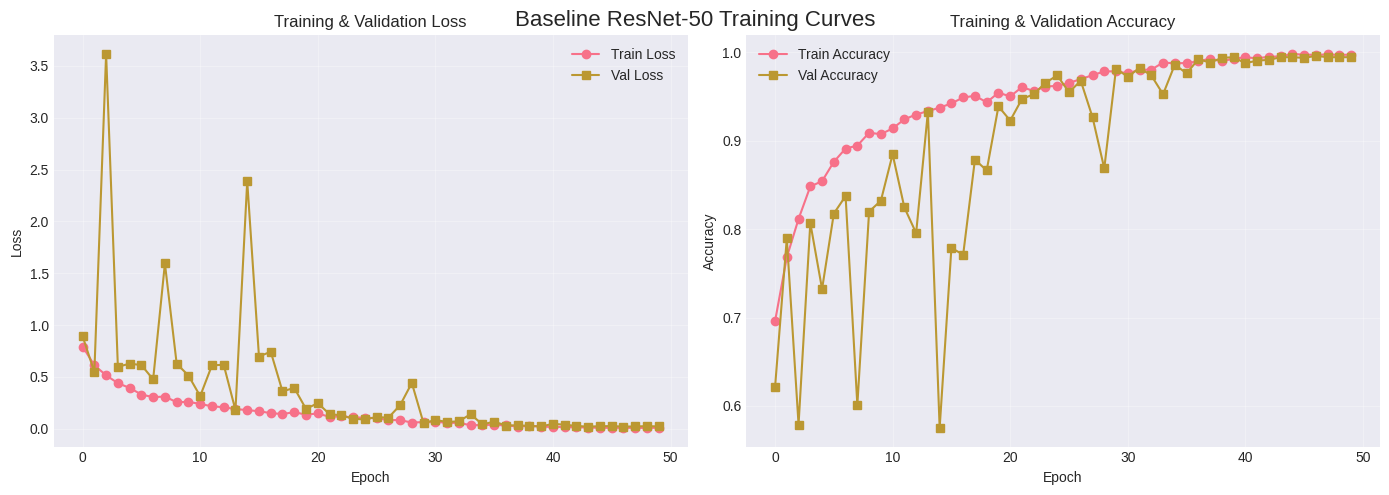

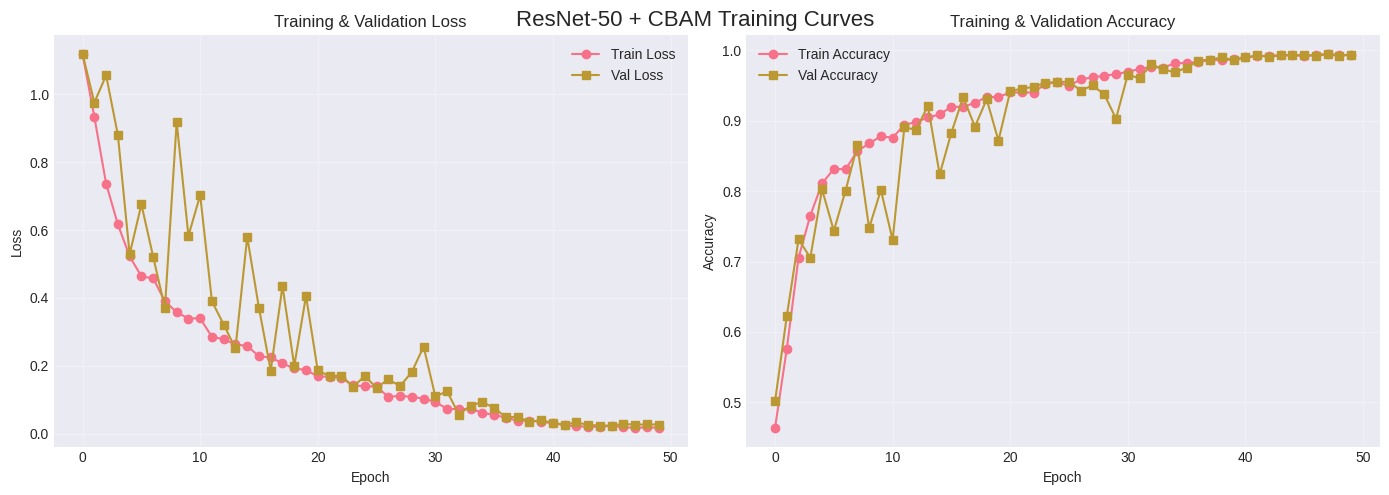

Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warni

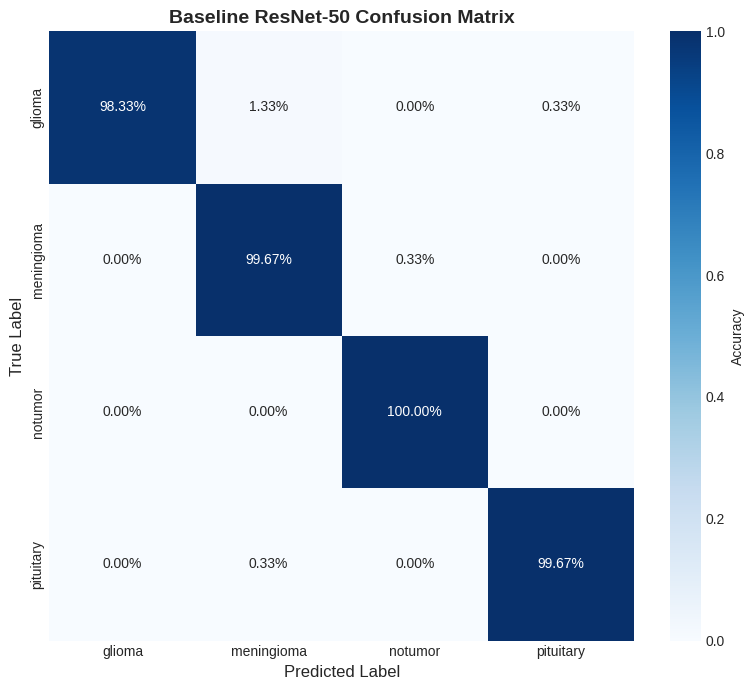

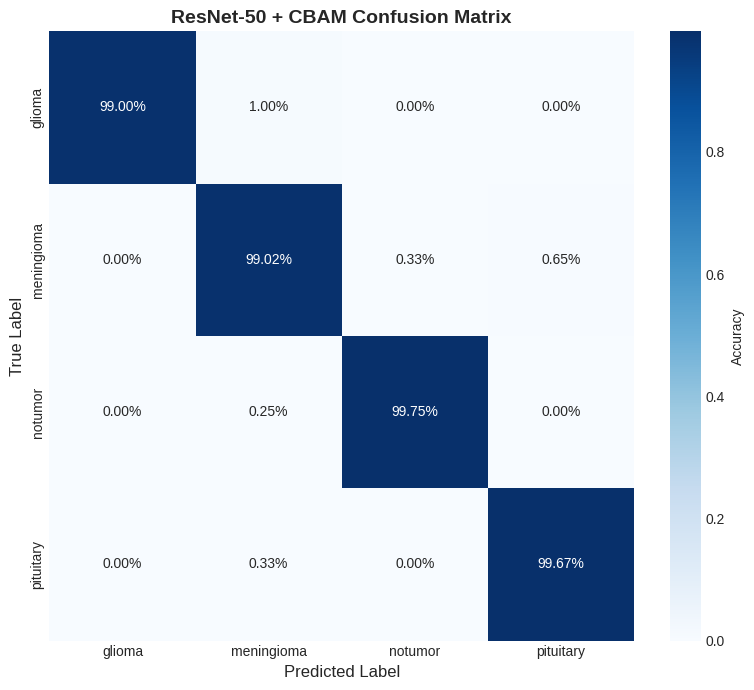


Overall Accuracy: 0.9947
Macro-Averaged F1: 0.9943

Class           Precision    Recall       F1           Support   
----------------------------------------------------------------------
glioma          1.0000       0.9833       0.9916       300       
meningioma      0.9839       0.9967       0.9903       306       
notumor         0.9975       1.0000       0.9988       405       
pituitary       0.9967       0.9967       0.9967       300       


Overall Accuracy: 0.9939
Macro-Averaged F1: 0.9936

Class           Precision    Recall       F1           Support   
----------------------------------------------------------------------
glioma          1.0000       0.9900       0.9950       300       
meningioma      0.9838       0.9902       0.9870       306       
notumor         0.9975       0.9975       0.9975       405       
pituitary       0.9934       0.9967       0.9950       300       



In [28]:
# Plot training curves for both models
fig1 = logger_baseline.plot_curves()
fig1.suptitle('Baseline ResNet-50 Training Curves', fontsize=16)
fig2 = logger_cbam.plot_curves()
fig2.suptitle('ResNet-50 + CBAM Training Curves', fontsize=16)
plt.show()

# Evaluate and plot confusion matrices for both models
val_metrics_baseline = evaluate(model_baseline, test_loader, criterion, DEVICE, idx_to_class)['metrics']
val_metrics_cbam = evaluate(model_cbam, test_loader, criterion, DEVICE, idx_to_class)['metrics']

fig3 = plot_confusion_matrix(val_metrics_baseline['confusion_matrix'], idx_to_class, title='Baseline ResNet-50 Confusion Matrix')
fig4 = plot_confusion_matrix(val_metrics_cbam['confusion_matrix'], idx_to_class, title='ResNet-50 + CBAM Confusion Matrix')
plt.show()

print_metrics(val_metrics_baseline, idx_to_class)
print_metrics(val_metrics_cbam, idx_to_class)

## 14. Example Inference & Saving Artifacts

Demonstrate loading a saved checkpoint, running inference, and saving model/metrics for reproducibility.

In [32]:
# Example: Load best CBAM model and run inference on test images
model_cbam_loaded, _ = build_model(mode='cbam', num_classes=CONFIG['num_classes'], pretrained=CONFIG['pretrained'], cbam_reduction=CONFIG['cbam_reduction'])
optimizer_cbam = optim.Adam(model_cbam_loaded.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
scheduler_cbam = CosineAnnealingLR(optimizer_cbam, T_max=CONFIG['epochs'])
load_checkpoint(model_cbam_loaded, optimizer_cbam, scheduler_cbam, 'cbam', CONFIG, DEVICE)

# Inference on a few test images
model_cbam_loaded.eval()
with torch.no_grad():
    images, labels = next(iter(test_loader))
    images, labels = to_device((images, labels), DEVICE)
    outputs = model_cbam_loaded(images)
    probs = F.softmax(outputs, dim=1)
    preds = outputs.argmax(dim=1)
    for i in range(5):
        print(f"Image {i+1}: True={idx_to_class[labels[i].item()]}, Pred={idx_to_class[preds[i].item()]}, Prob={probs[i][preds[i]].item():.4f}")

# Save final model and metrics
torch.save(model_cbam_loaded.state_dict(), os.path.join(CONFIG['checkpoint_dir'], 'cbam_final.pt'))
with open(os.path.join(CONFIG['checkpoint_dir'], 'cbam_final_metrics.json'), 'w') as f:
    json.dump(val_metrics_cbam, f, indent=2)
print("✓ Final model and metrics saved for reproducibility")

✓ Model (CBAM) built:
  - Total params: 26,032,740
  - Trainable params: 26,032,740
✓ Checkpoint loaded from epoch 48, best_metric=0.9944


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Image 1: True=glioma, Pred=glioma, Prob=1.0000
Image 2: True=glioma, Pred=glioma, Prob=1.0000
Image 3: True=glioma, Pred=glioma, Prob=0.9999
Image 4: True=glioma, Pred=glioma, Prob=0.9919
Image 5: True=glioma, Pred=glioma, Prob=0.9999


TypeError: Object of type ndarray is not JSON serializable

In [31]:
!ls -F

checkpoints/  sample_data/  Testing.zip  Training.zip
__MACOSX/     Testing/	    Training/
